In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

## Step 1 - Climate Analysis and Exploration

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
#investigate first row
meas = session.query(Measurement).first()
meas.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28511606b70>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [12]:
#investigate first row
stat = session.query(Station).first()
stat.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28511616b00>,
 'station': 'USC00519397',
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'latitude': 21.2716}

## Precipitation Analysis

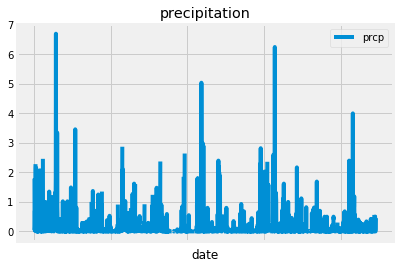

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
from sqlalchemy import func

# Calculate the date 1 year ago from the last data point in the database
maxdate = session.query(func.max(Measurement.date)).first()

maxdate = list(maxdate)
startdate = dt.datetime.strptime(maxdate[0], "%Y-%m-%d")- dt.timedelta(days=366)
# print(maxdate)
# print(startdate)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= startdate).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df =pd.DataFrame(data, columns =['date', 'prcp'])
df = df.set_index(df['date'], inplace = False)
df = df[['prcp']]
df.head()

# Sort the dataframe by date
df = df.sort_index()
#df = df.dropna()
df.head()

# # Use Pandas Plotting with Matplotlib to plot the data

df.plot(title = 'precipitation')
plt.show()

In [30]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [31]:
# Design a query to show how many stations are available in this dataset?
stations = len(session.query(Station.name).distinct().all())
#stationCount = len(stations)
stations

9

In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
a_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.station).desc()).all()
a_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_info = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station == 'USC00519281').first()
temp_info

(54.0, 85.0, 71.66378066378067)

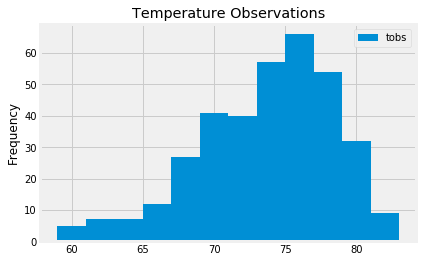

In [34]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
maxdate2 = session.query(func.max(Measurement.date)).filter(Measurement.station == 'USC00519281').first()
maxdate2 = list(maxdate2)
startdate2 = dt.datetime.strptime(maxdate2[0], "%Y-%m-%d") - dt.timedelta(days=366) 

temp_obv = session.query(Measurement.tobs).filter(Measurement.date >= startdate2).\
            filter(Measurement.station == 'USC00519281').all()

temp_obv_df = pd.DataFrame(temp_obv, columns = ['tobs'])
temp_obv_df.plot.hist(bins = 12, title = 'Temperature Observations')

plt.show()

## Step 2 - Climate App

In [19]:
# Design a Flask API based on the queries that you have just developed
# Use Flask to create your routes per instructions

#see file apps.py 
#https://github.com/bendgame/Eric_klep_hw10/blob/master/app.py

## Optional: Other Recommended Analyses

In [20]:
#The following are optional challenge queries. 
#These are highly recommended to attempt, but not required for the homework.

## Temperature Analysis

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-03-05', '2017-03-20'))

[(62.0, 71.02061855670104, 82.0)]


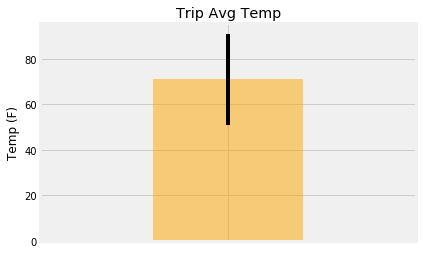

In [36]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
import numpy as np

#calculate temps
results = calc_temps('2017-03-05', '2017-03-20')

#set the results to a list
temps = list(np.ravel(results))

#bar graph
plt.xlim(0, 2)
plt.bar(1 ,temps[1], yerr = (temps[2] - temps[0]), alpha = .5, color = 'orange', tick_label="")
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.grid(True)
#plt.hlines([20,40,60,80], 0, 2)
plt.show()

In [37]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

t_rain = session.query(Station.station, func.sum(Measurement.prcp), Station.name, Station.elevation, Station.latitude,\
                Station.longitude).filter(Measurement.station == Station.station).filter(Measurement.date >= '2017-03-05').\
                filter(Measurement.date <= '2017-03-20').group_by(Station.station).\
                order_by(func.sum(Measurement.prcp).desc()).all()

#display
t_rain

[('USC00513117', 1.76, 'KANEOHE 838.1, HI US', 14.6, 21.4234, -157.8015),
 ('USC00519281',
  1.33,
  'WAIHEE 837.5, HI US',
  32.9,
  21.45167,
  -157.84888999999998),
 ('USC00514830',
  0.69,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  7.0,
  21.5213,
  -157.8374),
 ('USC00516128',
  0.36,
  'MANOA LYON ARBO 785.2, HI US',
  152.4,
  21.3331,
  -157.8025),
 ('USC00519397', 0.35, 'WAIKIKI 717.2, HI US', 3.0, 21.2716, -157.8168),
 ('USC00519523',
  0.35,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  19.5,
  21.33556,
  -157.71139),
 ('USC00517948', 0.06, 'PEARL CITY, HI US', 11.9, 21.3934, -157.9751)]

## Daily Rainfall Average

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
